# Pitch & Roll prediction w/Images

In [8]:
import gc
import os
import cv2
import json
import math
import pickle
import random
import platform
import numpy as np
import pandas as pd
import multiprocessing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [9]:
print(torch.__version__)
print(pl.__version__)

1.11.0
1.6.1


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

device: cuda
CPU count: 16
Platform: windows
number of workers: 0


# Constants

In [11]:
# change to appropriate location
TRAIN_FOLDER = "../3dmodel/test_4_episode_"
MODEL_NAME = "CNN_linear_img-to-PR"
MODEL_STATE_FOLDER = f"model_states/{MODEL_NAME}"
RESULT_FOLDER = f"../results/{MODEL_NAME}"
TRAIN_RESULT_FOLDER = f"training_results/{MODEL_NAME}"

In [12]:
if not os.path.exists(MODEL_STATE_FOLDER):
    os.mkdir(MODEL_STATE_FOLDER)
if not os.path.exists(TRAIN_RESULT_FOLDER):
    os.mkdir(TRAIN_RESULT_FOLDER)
if not os.path.exists(RESULT_FOLDER):
    os.mkdir(RESULT_FOLDER)

In [13]:
FRAMES_IN = 10
FRAMES_OUT = 60

N_EPISODES = 540
FRAMES_PER_EPISODE = 400

TRAIN_SIZE = 0.8
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

CUDA = device.type == 'cuda'

# Load data from episodes

In [14]:
# view first episode 's datapoints
filename = TRAIN_FOLDER + "1/"
data = []
labels = json.load(open(filename+"labels_0.json"))
ep1 = pd.DataFrame(labels)
ep1 = ep1.transpose()
ep1.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
ep1.head(5)

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468


In [15]:
img_tensors_array = []
filename = TRAIN_FOLDER + "1/"
for index, row in ep1.iterrows():
    img = cv2.imread(filename + str(index) + ".png")
    img_tensors_array.append(torch.Tensor(img))
ep1.head(5)

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468


In [16]:
len(img_tensors_array), img_tensors_array[0].shape

(400, torch.Size([54, 96, 3]))

In [17]:
# Function to normalize pixels
def norm_pixel(x):
    x = x.astype('float32')
    return (x*2)/255-1

# Function to denormalize pixels
def denorm_pixel(x):
    x = x.astype('float32')
    return (x+1)*255/2

In [18]:
# Function to normalize pitch and roll angles
def norm_pr(x, min = -90.0, max = 90.0):
    return ((x - min) * 2) / (max - min) - 1

# Function to denormalize pitch and roll angles
def denorm_pr(x, min = -90.0, max = 90.0):
    return ((x + 1) * (max - min))/2 + min

In [19]:
# load all data
episodes_data = []
img_tensors_array = []

for ep in tqdm(range(1, N_EPISODES+1)):
    folder = TRAIN_FOLDER + str(ep) + "/"
    filename = folder + "labels_0.json"
    labels = json.load(open(filename))
    for i in labels:
        # load image, normalize and convert to tensor
        img = cv2.imread(folder + str(i) + ".png")
        img = norm_pixel(img)
        img_tensors_array.append(torch.Tensor(img))

        # pitch and roll is read with labels[i] as [pitch, roll]
        episodes_data.append(labels[i])

# verify that 216.000 images were loaded
len(img_tensors_array), img_tensors_array[0].shape

  0%|          | 0/540 [00:00<?, ?it/s]

(216000, torch.Size([54, 96, 3]))

In [65]:
# build dataframe with pitch and roll, cast as float and normalize
p_r_df = pd.DataFrame(episodes_data)
p_r_df.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
p_r_df = p_r_df.astype({"pitch": float, "roll": float})
p_r_df['pitch'] = p_r_df['pitch'].apply(lambda x : norm_pr(x))
p_r_df['roll'] = p_r_df['roll'].apply(lambda x : norm_pr(x))
print(p_r_df.shape)
p_r_df.head(5)

(216000, 2)


,pitch,roll
0,0.176843,0.026205
1,0.158844,0.018893
2,0.069040,0.017904
3,0.013726,0.068616
4,0.014908,0.041061


In [66]:
# tranform the array of image tensors into one tensor of shape: (samples, height, width, channels)
img_tensor = torch.stack(img_tensors_array)
img_tensor_array = None # free this memory
img_tensor.shape

In [22]:
# Permute from (n, h, w, c) to (n, c, h, w) format for pytorch CNN
img_tensor = img_tensor.permute(0,3,1,2)
img_tensor.shape

torch.Size([216000, 3, 54, 96])

In [23]:
# clear memory
gc.collect()

18

# Create input and output sequences

In [24]:
# function to create sequences with one target column
def create_sequences(
        input_data: pd.DataFrame, 
        input_images,
        input_feature_columns,
        output_target_columns, 
        input_sequence_length=FRAMES_IN, 
        output_sequence_length=FRAMES_OUT,  
        episode_length = FRAMES_PER_EPISODE, 
        n_episodes = N_EPISODES
    ):
    sequences= []

    # make sequences per episode, one sequence can only hold data of one and the same episode!
    for n in tqdm(range(n_episodes)):

        for l in range(episode_length-output_sequence_length-input_sequence_length+1):
            
            i = l+(n*episode_length)

            # grab image input tensors from list with img_tensors
            sequence = input_images[i:i+input_sequence_length]

            # grab pr output sequence from dataframe
            target_position = i + input_sequence_length
            target = input_data.iloc[target_position:target_position+output_sequence_length].transpose()

            sequences.append((sequence, target))

    return sequences

In [25]:
# use images to predict pitch and roll
input_features = []
output_features = ["pitch", "roll"]
all_sequences = create_sequences(p_r_df, img_tensor, input_features, output_features)

  0%|          | 0/140 [00:00<?, ?it/s]

In [26]:
len(all_sequences), all_sequences[0][0].shape , all_sequences[0][1].shape

(46340, torch.Size([10, 3, 54, 96]), (2, 60))

In [27]:
# first input sequence
all_sequences[0][0].shape

torch.Size([10, 3, 54, 96])

In [28]:
# first output sequence
all_sequences[0][1].head()

,10,11,12,13,14,15,16,17,18,19,...,60,61,62,63,64,65,66,67,68,69
pitch,0.029492,-0.003735,0.152513,0.091190,0.093264,-0.012752,0.095015,0.162501,0.103608,0.077369,...,-0.04063,0.033109,-0.145496,0.017612,0.028490,0.129367,0.116320,0.022583,0.017130,-0.066031
roll,0.056080,0.063161,0.047668,0.016488,-0.019758,0.099169,0.120886,0.146725,0.127897,0.098694,...,0.01884,0.025537,0.007478,0.125550,0.101467,0.081079,0.029056,-0.044213,-0.067851,-0.083604


In [29]:
# loop for testing sequence integrity
"""
i = 0
for data in tqdm(all_sequences):
    input = data[0]
    output = data[1]

    episode = input.iloc[0]["episode"]
    episode1 = output.iloc[0]["episode"]
    
    if(episode1 != episode):
        print("Input and output from different episodes")
        break

    if (len(input['episode'].unique()) != 1):
        print("input seq: "+i+" contains data from different episodes")
        break
    
    if (len(output['episode'].unique()) != 1):
        print("output seq: "+i+" contains data from different episodes")
        break
    
    i += 1
"""

'\ni = 0\nfor data in tqdm(all_sequences):\n    input = data[0]\n    output = data[1]\n\n    episode = input.iloc[0]["episode"]\n    episode1 = output.iloc[0]["episode"]\n    \n    if(episode1 != episode):\n        print("Input and output from different episodes")\n        break\n\n    if (len(input[\'episode\'].unique()) != 1):\n        print("input seq: "+i+" contains data from different episodes")\n        break\n    \n    if (len(output[\'episode\'].unique()) != 1):\n        print("output seq: "+i+" contains data from different episodes")\n        break\n    \n    i += 1\n'

In [30]:
# Grab random subsets from all sequences for training and test data (without overlapping data)
data_size = len(all_sequences)
data_indices = list(np.arange(0, data_size, 1))

# train indices are random sample from all data indices
random.seed(42)
train_size = int(TRAIN_SIZE * data_size)
train_indices = random.sample(data_indices, train_size)

# test indices are the difference of all data indices and train indices
test_indices = list(set(data_indices) - set(train_indices))

print((len(train_indices) + len(test_indices)) <= data_size)
print("Training size:", len(train_indices),"| Test size:", len(test_indices))
print(train_indices[:10])
print(test_indices[:10])

True
Training size: 37072 | Test size: 9268
[41905, 7296, 1639, 18024, 16049, 14628, 9144, 6717, 44348, 35741]
[9, 32780, 32781, 32788, 32790, 24, 27, 28, 32795, 32797]


In [31]:
train_sequences = []
test_sequences = []

for idx in tqdm(train_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    train_sequences.append((seq,label))

for idx in tqdm(test_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    test_sequences.append((seq,label))

print((len(train_sequences) + len(test_sequences)) <= len(all_sequences))
print(len(train_sequences), train_sequences[0][0].shape, train_sequences[0][1].shape) 
print(len(test_sequences), test_sequences[0][0].shape, test_sequences[0][1].shape)

  0%|          | 0/37072 [00:00<?, ?it/s]

  0%|          | 0/9268 [00:00<?, ?it/s]

True
37072 torch.Size([10, 3, 54, 96]) (2, 60)
9268 torch.Size([10, 3, 54, 96]) (2, 60)


## Pytorch Dataset and DataLoader

In [32]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        input_sequence, output_sequence = self.sequences[index]

        return dict(
            input = input_sequence,
            output = torch.Tensor(output_sequence.to_numpy())
        )

In [33]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = BATCH_SIZE):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    # turns normal list object into Dataset object
    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

In [34]:
data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

In [35]:
# batch size first
for batch in data_module.train_dataloader():
    print(batch["input"].shape)
    print(batch["output"].shape)
    break

torch.Size([64, 10, 3, 54, 96])
torch.Size([64, 2, 60])


## CNN Model

In [36]:
class CNN_encoder(nn.Module):

    def __init__(self, channels=3):
        super(CNN_encoder, self).__init__()

        # outputs a tensor of shape (batch, out_channels, h/2/2/2, w/2/2/2)
        self.cnn_encoder = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=8, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
    
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        batch_size = x.size(0)

        # x is of shape (batch, seq_lenth, channels, height, width)
        # iterate over the sequence and encode a feature vector for each image
        img_features = [self.cnn_encoder(x[:,i,:,:,:].squeeze(1)) for i in range(x.size(1))]
        
        # flatten feature vectors in img_features
        img_features = [img.reshape(batch_size, -1) for img in img_features]

        # convert list of vectors into tensor of shape: (batch, len(img_features), features)
        img_features = torch.stack(img_features, 1)

        # reshape into (batch, 1, n*features)
        img_features = img_features.reshape(batch_size, -1).unsqueeze(1)

        return img_features

In [37]:
# get the first batch out of the dataloader for testing purposes
for batch in data_module.train_dataloader():
    x_train = batch["input"]
    y_train = batch["output"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 10, 3, 54, 96]) torch.Size([64, 2, 60])


In [38]:
model = CNN_encoder()
img_features = model.forward(x_train)
img_features.shape

torch.Size([64, 1, 23040])

In [39]:
class Linear(nn.Module):
    def __init__(self, input_size, output_size=FRAMES_OUT):
        super(Linear, self).__init__()

        self.input_size = input_size
        self.output_size = output_size

        self.fc1 = nn.Linear(input_size, int(input_size/2))
        self.fc2 = nn.Linear(int(input_size/2), int(input_size/4))
        self.fc3 = nn.Linear(int(input_size/4), output_size*2)

    def forward(self, x:torch.Tensor):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [40]:
linear = Linear(FRAMES_IN*2304)
o = linear.forward(img_features)
o.shape

torch.Size([64, 1, 120])

In [41]:
class CNN_linear(nn.Module):
    def __init__(self, linear_input_size, channels=3, output_size=FRAMES_OUT):
        super(CNN_linear, self).__init__()

        self.output_size = output_size

        self.cnn_encoder = CNN_encoder(channels)
        self.linear = Linear(linear_input_size, output_size)

    def forward(self, x:torch.Tensor):
        batch_size = x.size(0)

        x = self.cnn_encoder(x)
        x = self.linear(x)

        output = x.reshape(batch_size, 2, self.output_size)

        return output

In [42]:
model = CNN_linear(FRAMES_IN*2304)
o = model(x_train)
o.shape

torch.Size([64, 2, 60])

# Training

In [43]:
for batch in data_module.val_dataloader():
    x_train = batch["input"]
    y_train = batch["output"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 10, 3, 54, 96]) torch.Size([64, 2, 60])


In [44]:
model = CNN_linear(linear_input_size=FRAMES_IN*2304, output_size=FRAMES_OUT)
ypred = model.forward(x_train)
ypred.shape

torch.Size([64, 2, 60])

### Training loop

In [45]:
torch.cuda.empty_cache()
gc.collect()

54

In [46]:
model = CNN_linear(linear_input_size=FRAMES_IN*2304, output_size=FRAMES_OUT)

if CUDA:
    model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# TRACKERS
train_losses_epoch = []
val_losses_epoch = []
train_losses_batch = []
val_losses_batch = []

for epoch in tqdm(range(NUM_EPOCHS)):
    
    # validation loss with initial weights
    with torch.no_grad():
        i = 0
        total_batch_loss = 0
        for batch in data_module.val_dataloader():
            print(f"batch {i}", end='\r')
            x_val = batch["input"]
            y_val = batch["output"]
            i += 1

            if CUDA: 
                x_val = batch["input"].cuda()
                y_val = batch["output"].cuda()
            
            # Predict on forward pass 
            y_pred = model.forward(x_val)
            
            loss = criterion(y_pred, y_val)
            total_batch_loss += loss.item()
            val_losses_batch.append(loss.item())

        mean_val_loss = total_batch_loss/i
        val_losses_epoch.append(mean_val_loss)
        val_loss = round(mean_val_loss, 6)

    i = 0 
    total_batch_loss = 0

    for batch in data_module.train_dataloader():
        print(f"batch {i}", end='\r')
        i += 1
        x_train = batch["input"]
        y_train = batch["output"]

        if CUDA: 
            x_train = batch["input"].cuda()
            y_train = batch["output"].cuda()
        
        # Predict on forward pass 
        y_pred = model.forward(x_train)

        # Calculate loss/error
        loss = criterion(y_pred, y_train)
        train_losses_batch.append(loss.item())
        total_batch_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    mean_train_loss = total_batch_loss/i
    train_losses_epoch.append(mean_train_loss)
    train_loss = round(mean_train_loss, 6)

    print(f"EPOCH {epoch} training loss: {train_loss} | validation loss: {val_loss}")

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH 0 training loss: 2.152485 | validation loss: 0.004299


KeyboardInterrupt: 

### Save and load model

In [ ]:
# save train losses per epoch
filename = f'{TRAIN_RESULT_FOLDER}/train_loss_{FRAMES_IN}in_{FRAMES_OUT}out_{NUM_EPOCHS}epochs'
with open(filename, 'wb') as f: 
    pickle.dump(train_losses_epoch, f)
# save val losses per epoch
filename = f'{TRAIN_RESULT_FOLDER}/val_loss_{FRAMES_IN}in_{FRAMES_OUT}out_{NUM_EPOCHS}epochs'
with open(filename, 'wb') as f: 
    pickle.dump(val_losses_epoch, f)

In [ ]:
filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
torch.save(model.state_dict(), filename)

In [ ]:
filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
loaded_model = CNN_linear(linear_input_size=FRAMES_IN*2304, output_size=FRAMES_OUT)
loaded_model.load_state_dict(torch.load(filename))
if CUDA: 
    loaded_model = loaded_model.cuda()
loaded_model.eval()

CNN_linear(
  (cnn_encoder): CNN_encoder(
    (cnn_encoder): Sequential(
      (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (linear): Linear(
    (fc1): Linear(in_features=23040, out_features=11520, bias=True)
    (fc2): Linear(in_features=11520, out_features=5760, bias=True)
    (fc3): Linear(in_features=5760, out_features=120, bias=True)
  )
)

# Training results

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

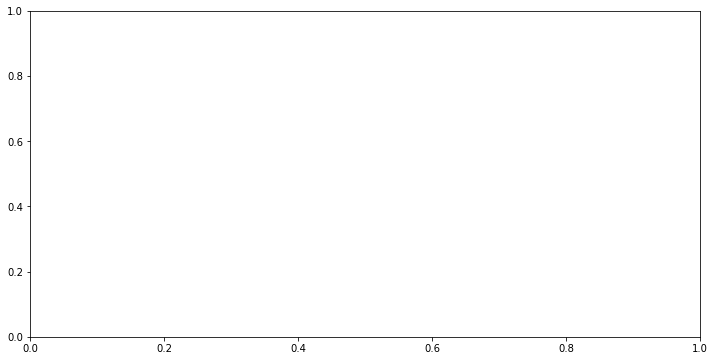

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(range(NUM_EPOCHS), train_losses_epoch, label='training loss')
plt.plot(range(NUM_EPOCHS), val_losses_epoch, label='validation loss')
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.title("Training and validation loss per epoch")
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/train-test-loss_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

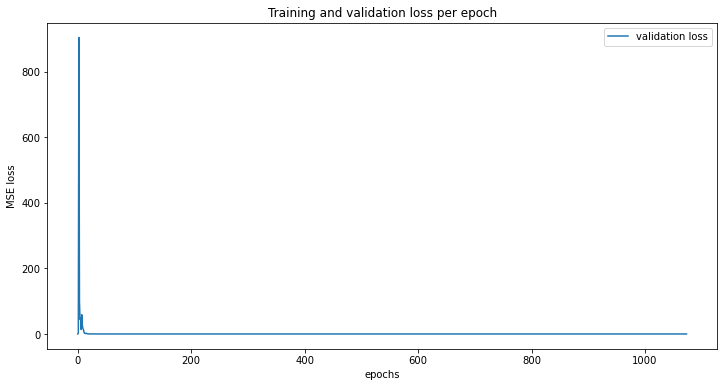

In [63]:
plt.figure(figsize=(12, 6))
#plt.plot(train_losses_batch, label='training loss')
plt.plot(train_losses_batch, label='validation loss')
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.title("Training and validation loss per epoch")
plt.legend()
plt.show()

In [64]:
i = 0
model = CNN_linear(linear_input_size=FRAMES_IN*2304, output_size=FRAMES_OUT)

for batch in data_module.train_dataloader():
    x_train = batch["input"]
    y_train = batch["output"]  
    y_pred = model.forward(x_train)
    loss = criterion(y_pred, y_train)
    print(f"batch {i} loss: {loss.item()}")
    i += 1
    

batch 0 loss: 0.0043000103905797005
batch 1 loss: 0.003517707111313939
batch 2 loss: 0.0036983033642172813
batch 3 loss: 0.004068177659064531
batch 4 loss: 0.005474982783198357
batch 5 loss: 0.004256133455783129
batch 6 loss: 0.004183002281934023
batch 7 loss: 0.004182619042694569
batch 8 loss: 0.0037457121070474386
batch 9 loss: 0.004126837942749262
batch 10 loss: 0.004579673521220684
batch 11 loss: 0.003993639722466469
batch 12 loss: 0.0034100115299224854
batch 13 loss: 0.004838759079575539
batch 14 loss: 0.004137094132602215
batch 15 loss: 0.0040208762511610985
batch 16 loss: 0.004367125686258078
batch 17 loss: 0.004724704660475254
batch 18 loss: 0.00380000495351851
batch 19 loss: 0.004384302534162998
batch 20 loss: 0.004842783790081739
batch 21 loss: 0.004478572402149439
batch 22 loss: 0.004125578328967094
batch 23 loss: 0.004608229734003544
batch 24 loss: 0.004231704864650965
batch 25 loss: 0.004826245829463005
batch 26 loss: 0.00324220210313797
batch 27 loss: 0.003965536132454872

In [59]:
model = CNN_linear(linear_input_size=FRAMES_IN*2304, output_size=FRAMES_OUT)
y_pred = model.forward(x_train)
y_pred.shape

torch.Size([64, 2, 60])

In [62]:
loss = criterion(y_pred, y_train)
loss.item()

0.0036315203178673983

# Testing

In [ ]:
# get first I/O-sequence of test dataset for visualizing a prediction
for batch in data_module.test_dataloader():
    x_test = batch["input"]
    y_test = batch["output"]
    break

if CUDA:
    x_test = x_test.cuda()
    y_test = y_test.cuda()

print(x_test.shape, y_test.shape)

torch.Size([1, 10, 3, 54, 96]) torch.Size([1, 2, 60])


In [ ]:
criterion = nn.MSELoss()

# make one prediction for visualization
with torch.no_grad():
    y_pred = loaded_model(x_test.squeeze(1))
    loss = criterion(y_pred, y_test)

    # clean up tensor and round results to visually compare predicted sequence
    a = y_pred.squeeze(0)[0].tolist()
    a = [round(num, 4) for num in a]

    b = y_test.squeeze(0)[0].tolist()
    b = [round(num, 4) for num in b]

    print(f'predicted pitch: {a}\nreal pitch:\t {b}')
    print("loss:", round(loss.item(), 6))

# squeeze out batch size and convert into cpu format for plotting
x_test.squeeze(0).shape
input_sequence = x_test.squeeze(0).cpu()
output_sequence = y_test.squeeze(0).cpu()
predicted_sequence = y_pred.squeeze(0).cpu()
input_sequence.shape, output_sequence.shape, predicted_sequence.shape

predicted pitch: [0.0638, 0.1482, 0.0634, 0.1419, -0.0632, -0.0303, -0.1002, 0.1115, 0.0772, 0.1913, 0.1398, 0.0463, 0.0753, -0.0097, 0.0359, 0.0842, 0.0137, -0.0045, 0.0017, 0.0176, 0.0289, -0.0673, -0.0016, 0.0633, -0.0906, -0.1441, -0.2138, 0.0352, 0.2151, 0.1709, 0.2073, 0.1703, 0.2481, 0.1555, 0.1014, -0.0618, 0.0739, -0.0738, -0.033, 0.0415, 0.0991, -0.0098, 0.0394, -0.126, -0.0321, -0.0707, 0.07, 0.0778, 0.0093, 0.0038, -0.0324, 0.041, -0.1601, 0.0658, -0.0195, -0.003, -0.05, -0.1063, -0.1206, 0.063]
real pitch:	 [0.0774, 0.0955, 0.0615, 0.1166, -0.1029, -0.039, -0.0965, 0.115, 0.0672, 0.1892, 0.1413, 0.0972, 0.0782, -0.0112, 0.0431, 0.1098, 0.081, 0.0346, 0.0441, 0.0603, 0.0499, -0.0585, 0.0075, 0.0952, -0.1104, -0.1677, -0.1942, 0.0601, 0.1967, 0.1765, 0.1818, 0.1645, 0.2538, 0.2093, 0.1261, -0.0085, 0.1973, 0.0156, 0.0242, 0.059, 0.1047, -0.0406, 0.0331, -0.1455, 0.0176, 0.0285, 0.1294, 0.1163, 0.0226, 0.0171, -0.066, 0.0246, -0.1826, 0.0472, -0.0261, -0.0216, -0.0763, -0.133

(torch.Size([10, 3, 54, 96]), torch.Size([2, 60]), torch.Size([2, 60]))

### Prediction vs. real on first test I/O-sequence

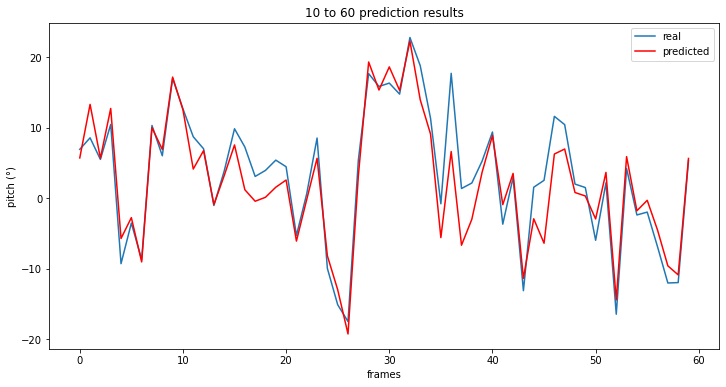

In [ ]:
frames = np.arange(0,FRAMES_OUT)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(output_sequence[0].apply_(denorm_pr), label="real")
ax.plot(predicted_sequence[0].apply_(denorm_pr), color="red", label='predicted')
ax.set_xlabel('frames')
ax.set_ylabel('pitch (°)')
ax.set_title(f'{FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/1ep_pitch-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

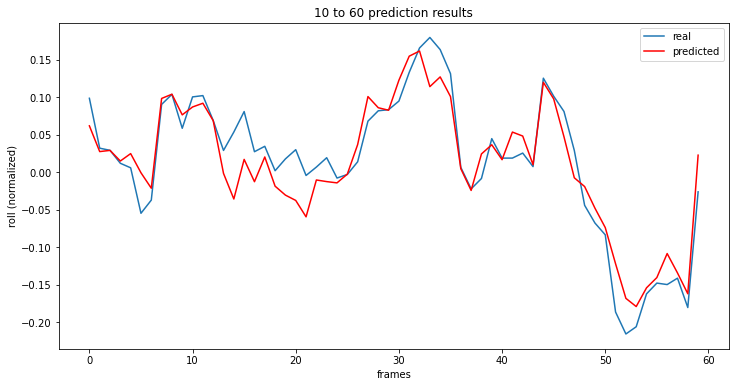

In [ ]:
frames = np.arange(0,FRAMES_OUT)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(output_sequence[1], label="real")
ax.plot(predicted_sequence[1], color="red", label='predicted')
ax.set_xlabel('frames')
ax.set_ylabel('roll (normalized)')
ax.set_title(f'{FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/1ep_roll-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

### Full test loop

In [ ]:
predictions = []
labels = []

with torch.no_grad():
    for batch in tqdm(data_module.test_dataloader()):
        x_test = batch["input"]
        y_test = batch["output"]

        if CUDA:
            x_test = x_test.cuda()

        output = loaded_model(x_test.squeeze(1))

        # squeeze out batch size which is = 1 for test dataset
        predictions.append(output.cpu().squeeze(0))
        labels.append(y_test.squeeze(0))

  0%|          | 0/9268 [00:00<?, ?it/s]

In [ ]:
predictions[0][0]

tensor([ 0.0638,  0.1482,  0.0634,  0.1419, -0.0632, -0.0303, -0.1002,  0.1115,
         0.0772,  0.1913,  0.1398,  0.0463,  0.0753, -0.0097,  0.0359,  0.0842,
         0.0137, -0.0045,  0.0017,  0.0176,  0.0289, -0.0673, -0.0016,  0.0633,
        -0.0906, -0.1441, -0.2138,  0.0352,  0.2151,  0.1709,  0.2073,  0.1703,
         0.2481,  0.1555,  0.1014, -0.0618,  0.0739, -0.0738, -0.0330,  0.0415,
         0.0991, -0.0098,  0.0394, -0.1260, -0.0321, -0.0707,  0.0700,  0.0778,
         0.0093,  0.0038, -0.0324,  0.0410, -0.1601,  0.0658, -0.0195, -0.0030,
        -0.0500, -0.1063, -0.1206,  0.0630])

In [ ]:
# Predictions[0] = tensor object
# Predictions[0][0] = pitch value
# Predictions[0][1] = roll value

pitch_predictions = []
roll_predictions = []

pitch_label = []
roll_label = []

for i in range(len(predictions)):
    pitch_predictions.append(predictions[i][0])
    roll_predictions.append(predictions[i][1])
    pitch_label.append(labels[i][0])
    roll_label.append(labels[i][1])

pitch_predictions[0].shape, roll_predictions[0].shape, pitch_label[0].shape, roll_label[0].shape

(torch.Size([60]), torch.Size([60]), torch.Size([60]), torch.Size([60]))

### Average loss-per-frame over all datapoints

In [ ]:
# function that returns a list with loss-values per frame
def loss_per_frame(predicted_sequence, real_sequence):
    loss_per_frame = []
    criterion = nn.MSELoss()
    if predicted_sequence.shape != real_sequence.shape:
        return loss_per_frame
    for i in range(len(predicted_sequence)):
        loss = criterion(predicted_sequence[i], real_sequence[i])
        loss_per_frame.append(loss.item())
    return loss_per_frame

In [ ]:
# calculate mean loss per frame over all test data
total = len(pitch_predictions)
pitch_total = np.zeros(FRAMES_OUT, dtype=np.float64)
roll_total = np.zeros(FRAMES_OUT, dtype=np.float64)

for i in tqdm(range(len(pitch_predictions))):
    pitch_lpf = loss_per_frame(pitch_predictions[i], pitch_label[i])
    roll_lpf = loss_per_frame(roll_predictions[i], roll_label[i])
    pitch_total += pitch_lpf
    roll_total += roll_lpf

pitch_lpf_mse = pitch_total / total
roll_lpf_mse = roll_total / total

  0%|          | 0/9268 [00:00<?, ?it/s]

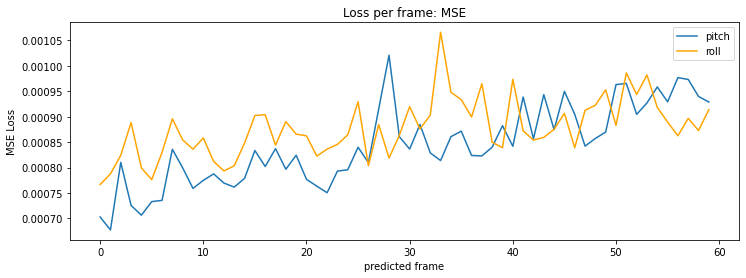

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(pitch_lpf_mse, label='pitch')
plt.plot(roll_lpf_mse, color='orange', label='roll')
plt.xlabel('predicted frame')
plt.ylabel('MSE Loss')
plt.title('Loss per frame: MSE')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/LPF-MSE_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

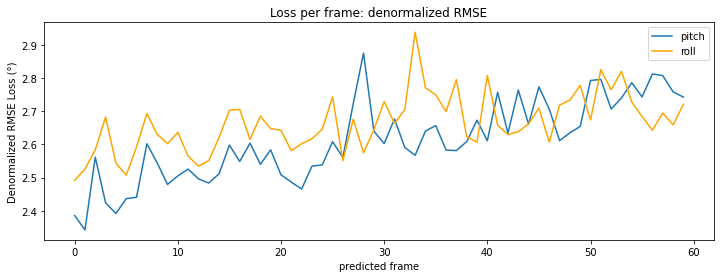

In [ ]:
pitch_lpf_rmse = np.sqrt(pitch_lpf_mse)
roll_lpf_rmse = np.sqrt(roll_lpf_mse)
denorm = lambda x: denorm_pr(x)
vfunc = np.vectorize(denorm)
plt.figure(figsize=(12, 4))
plt.plot(vfunc(pitch_lpf_rmse), label='pitch')
plt.plot(vfunc(roll_lpf_rmse), color='orange', label='roll')
plt.xlabel('predicted frame')
plt.ylabel('Denormalized RMSE Loss (°)')
plt.title('Loss per frame: denormalized RMSE')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/LPF-denorm-RMSE_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

### MSE results pitch

In [ ]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = 0
loss0 = 0

for i in range(n):
    loss += criterion(pitch_label[i], pitch_predictions[i]).item()
    loss0 += criterion(pitch_label[i], loss0_tensor).item()

mse = round(loss/n, 5)
rmse = round(math.sqrt(loss/n), 4)
mse0 = round(loss0/n, 5)
rmse0 = round(math.sqrt(loss0/n), 4)

print("Pitch prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Pitch prediction
   MSE: 0.00084
   RMSE: 0.029
   RMSE denorm: 2.61°
Zero prediction
   MSE 0: 0.00369
   RMSE 0: 0.0607
   RMSE denorm: 5.46°
Improvement on zero prediction:
   MSE delta%: 439.29 %
   RMSE delta%: 209.31 %


### MSE results roll

In [ ]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = 0
loss0 = 0

for i in range(n):
    loss += criterion(roll_label[i], roll_predictions[i]).item()
    loss0 += criterion(roll_label[i], loss0_tensor).item()

mse = round(loss/n, 5)
rmse = round(math.sqrt(loss/n), 4)
mse0 = round(loss0/n, 5)
rmse0 = round(math.sqrt(loss0/n), 4)

print("Roll prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Roll prediction
   MSE: 0.00088
   RMSE: 0.0296
   RMSE denorm: 2.66°
Zero prediction
   MSE 0: 0.00443
   RMSE 0: 0.0665
   RMSE denorm: 5.98°
Improvement on zero prediction:
   MSE delta%: 503.41 %
   RMSE delta%: 224.66 %
